In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

import folium
import requests

from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from yellowbrick.cluster import KElbowVisualizer

import sklearn.metrics as sm
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report

c:\users\alfre\documents\env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
CLIENT_ID = 'HW2BMKCIJMFDHVHTRUGVFPB4XJL1U5EYVKOYW0BZ0FRRAX3V' # your Foursquare ID
CLIENT_SECRET = 'J2OZP1INRNJFY5TJDQDUNZDGIHCOLNUJAHUEV0ZPAXZKTUMR' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 100

In [3]:
df = pd.read_html('https://purlp.com/taguig/')[0]
Taguig_zip = df.iloc[1:]

Taguig_zip = Taguig_zip.rename(columns = Taguig_zip.iloc[0]).drop(Taguig_zip.index[0])
Taguig_zip = Taguig_zip[['Postal Codes', 'Locations']]


Taguig_zip.head()

,Postal Codes,Locations
2,1630,Bagumbayan; Pinagsama (including EP Village)
3,1636,Bay Breeze Executive Village
4,1636,"Maharlika Village, Taguig"
5,1636,"Tanyag, Taguig"
6,1631,Bicutan


In [4]:
ph_zip = pd.read_csv('C:\\Users\\alfre\\Documents\\env\\IBM_Capstone\\Coursera_Capstone\\PH.csv', sep=',', encoding='latin-1', header=0)
ph_zip.head()

,Zip Code,Neighborhood,Latitude,Longitude
0,1630,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676
1,1636,Bay Breeze Executive Village,14.512020,121.078615
2,1636,"Maharlika Village, Taguig",14.498195,121.051167
3,1636,"Tanyag, Taguig",14.476468,121.044121
4,1631,Bicutan,14.497467,121.045143


In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [6]:
# Select first building (which in our case is BedokVille):
#neighborhood_name = ph_zip.loc[0, 'Neighborhood']
neighborhood_latitude = 14.505
neighborhood_longitude = 121.0509
# limit of number of venues returned by Foursquare API
LIMIT = 100 
radius = 500

In [7]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [8]:
venues = results['response']['groups'][0]['items']
nearby_venues = pd.json_normalize(venues)

In [9]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,North Park Noodles,Chinese Restaurant,14.508299,121.050637
1,McDonald's,Fast Food Restaurant,14.505924,121.052106
2,SM Hypermarket,Market,14.508448,121.050577
3,Jollibee,Fast Food Restaurant,14.504747,121.052948
4,Puregold FTI,Supermarket,14.506034,121.052007


In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
nearby_venues

,name,categories,lat,lng
0,North Park Noodles,Chinese Restaurant,14.508299,121.050637
1,McDonald's,Fast Food Restaurant,14.505924,121.052106
2,SM Hypermarket,Market,14.508448,121.050577
3,Jollibee,Fast Food Restaurant,14.504747,121.052948
4,Puregold FTI,Supermarket,14.506034,121.052007
5,Plato Wraps SM Mall of Asia,Food Truck,14.508346,121.050556
6,BDO,ATM,14.508447,121.050489


In [12]:
taguig_venues = getNearbyVenues(names=ph_zip['Neighborhood'],
                                   latitudes=ph_zip['Latitude'],
                                   longitudes=ph_zip['Longitude']
                                  )
taguig_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,McDonald's,14.516306,121.051504,Fast Food Restaurant
1,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,C5 Waterfun,14.516760,121.051396,Sculpture Garden
2,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,Heritage Park Jogging Oval,14.519163,121.049195,Park
3,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,Kuyang Food Trip ng Pinoy Head Office,14.514962,121.048027,Food Truck
4,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,Cebuana Lhuiller,14.516615,121.051414,Jewelry Store


In [13]:
taguig_venues = taguig_venues[(taguig_venues['Venue Category']!='Intersection')
                             &(taguig_venues['Venue']!='C5 Waterfun')
                             &(taguig_venues['Venue']!='Cebuana Lhuiller')
                             &(taguig_venues['Venue']!='SLEX C5 Toll')]

In [14]:
venues_map = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=12.5)
# add a red circle marker to represent the Taguig Neighborhoods

for i in ph_zip.index:
    folium.CircleMarker(
        [ph_zip['Latitude'][i], ph_zip['Longitude'][i]],
        radius=50,
        color='red',
        popup=ph_zip['Neighborhood'][i],
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.1
    ).add_to(venues_map)



# add all venues as blue circle markers
for j in taguig_venues.index:
    folium.Marker(
        [taguig_venues['Venue Latitude'][j], taguig_venues['Venue Longitude'][j]],
        radius=5,
        color='blue',
        popup=taguig_venues['Venue'][j],
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

venues_map

In [15]:
print(taguig_venues['Venue Category'].unique().shape)


(107,)


In [16]:
taguig_venues['Flag Food'] = np.where(taguig_venues['Venue Category'].str.contains(pat='restaurant',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='food',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='Snack',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='Coffee',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='bagel',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='cafeteria',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='bakery',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='bbq',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='ice cream',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='dessert',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='pizza',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='burger',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='tea',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='Wings Joint',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='fried chicken Joint',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='diner',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='donut',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='Café',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='Sandwich',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='cupcake',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='breakfast',case=False)
                                      ,1,0)

taguig_venues['Flag Recreation'] = np.where(taguig_venues['Venue Category'].str.contains(pat='park',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='playground',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='recreation',case=False)
                                      ,1,0)

taguig_venues['Flag Fitness'] = np.where(taguig_venues['Venue Category'].str.contains(pat='gym',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='basketball',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='soccer',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='golf',case=False) 
                                      |taguig_venues['Venue Category'].str.contains(pat='Athletics & Sports',case=False) 
                                      ,1,0)

taguig_venues['Flag Market'] = np.where(taguig_venues['Venue Category'].str.contains(pat='market',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='grocery',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='convenience store',case=False)
                                      ,1,0)

taguig_venues['Flag Utility'] = np.where(taguig_venues['Venue Category'].str.contains(pat='pharmacy',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='auto',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='motorcycle',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='health',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='beauty',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='Sporting Goods',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='electronics',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='laundromat',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='veterinarian',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='mobile phone',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='department store',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='clothing',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='shoe',case=False)
                                      ,1,0)

taguig_venues['Flag Leisure'] = np.where(taguig_venues['Venue Category'].str.contains(pat='museum',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='nightclub',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='mall',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='bar',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='bookstore',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='spa',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='multiplex',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='bowling alley',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='casino',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='pool',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='gift',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='movie',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='jewelry',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='theater',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='cosmetics',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='gaming',case=False)
                                      ,1,0)
#Checks Redandancy and nonflagging

Food_test = taguig_venues['Flag Food'].sum()
Recreation_test = taguig_venues['Flag Recreation'].sum()
Fitness_test = taguig_venues['Flag Fitness'].sum()
Market_test = taguig_venues['Flag Market'].sum()
Utility_test = taguig_venues['Flag Utility'].sum()
Leisure_test = taguig_venues['Flag Leisure'].sum()

Sum_Test = Food_test + Recreation_test + Fitness_test + Market_test + Utility_test + Leisure_test
print('Test if the number of Venue Category',taguig_venues.shape[0],'is equal to',Sum_Test,'the number of Categorized Amenities')


#Removes Transport and other venue categories lacking foursquare Data
tauig_venues = taguig_venues[(taguig_venues['Flag Food']==1)
             |(taguig_venues['Flag Recreation']==1)
             |(taguig_venues['Flag Fitness']==1)
             |(taguig_venues['Flag Market']==1)
             |(taguig_venues['Flag Utility']==1)
             |(taguig_venues['Flag Leisure']==1)]

taguig_venues.reset_index(drop=True, inplace=True)

Test if the number of Venue Category 389 is equal to 370 the number of Categorized Amenities


In [17]:
taguig_venues.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Flag Food,Flag Recreation,Flag Fitness,Flag Market,Flag Utility,Flag Leisure
0,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,McDonald's,14.516306,121.051504,Fast Food Restaurant,1,0,0,0,0,0
1,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,Heritage Park Jogging Oval,14.519163,121.049195,Park,0,1,0,0,0,0
2,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,Kuyang Food Trip ng Pinoy Head Office,14.514962,121.048027,Food Truck,1,0,0,0,0,0
3,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,Philippine Veterans Museum,14.514209,121.047617,History Museum,0,0,0,0,0,1
4,Bay Breeze Executive Village,14.512020,121.078615,NAIA Canteen,14.509831,121.080218,Cafeteria,1,0,0,0,0,0
5,Bay Breeze Executive Village,14.512020,121.078615,Siomai House,14.514723,121.081629,Food Truck,1,0,0,0,0,0
6,Bay Breeze Executive Village,14.512020,121.078615,Phines Bakery,14.516211,121.077801,Bakery,1,0,0,0,0,0
7,Bay Breeze Executive Village,14.512020,121.078615,All Day Supermarket,14.512756,121.074039,Market,0,0,0,1,0,0
8,"Maharlika Village, Taguig",14.498195,121.051167,Ayala Malls Arca South,14.496085,121.047928,Shopping Mall,0,0,0,0,0,1
9,"Maharlika Village, Taguig",14.498195,121.051167,McDonald's,14.502004,121.051440,Fast Food Restaurant,1,0,0,0,0,0


In [18]:
#Uncomment the succeeding lines to Check What Venue Category an amenity is flagged as


#taguig_venues[taguig_venues['Flag Food'] == 1]['Venue Category']
#taguig_venues[taguig_venues['Flag Recreation'] == 1]['Venue Category']
#taguig_venues[taguig_venues['Flag Fitness'] == 1]['Venue Category']
#taguig_venues[taguig_venues['Flag Market'] == 1]['Venue Category']
#taguig_venues[taguig_venues['Flag Utility'] == 1]['Venue Category']
#taguig_venues[taguig_venues['Flag Leisure'] == 1]['Venue Category']

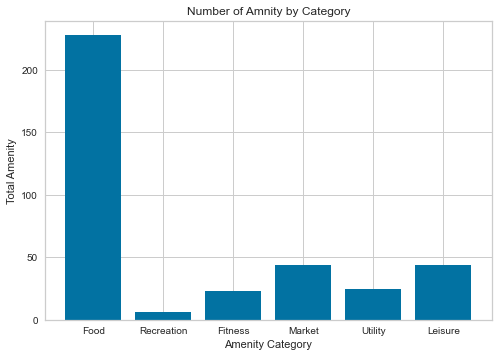

In [19]:
count_amenities = [Food_test, Recreation_test, Fitness_test ,Market_test, Utility_test, Leisure_test]
amenities = ['Food', 'Recreation', 'Fitness', 'Market', 'Utility', 'Leisure']

x_pos = [i for i, _ in enumerate(amenities)]

plt.bar(x_pos, count_amenities)
plt.xlabel("Amenity Category")
plt.ylabel("Total Amenity")
plt.title("Number of Amnity by Category")

plt.xticks(x_pos, amenities)

plt.show()

In [20]:
X = taguig_venues[['Venue Latitude','Venue Longitude']]
#Y = taguig_venues['Venue Longitude']

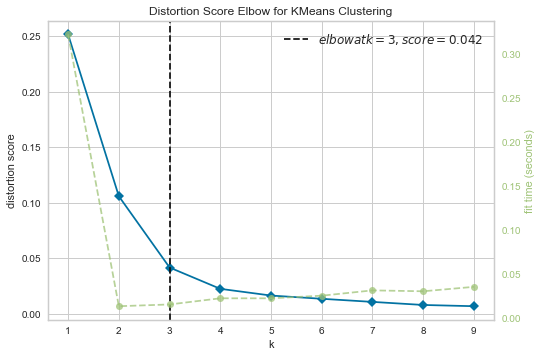

In [24]:
visualizer = KElbowVisualizer(KMeans(), k=(1,10))
visualizer.fit(X)
visualizer.show()

In [29]:
clustering = KMeans(n_clusters=3)
clustering.fit_predict(X)
clustering.cluster_centers_

array([[ 14.52938832, 121.06034117],
       [ 14.48536293, 121.04476843],
       [ 14.52002801, 121.02099602]])